In [151]:
%matplotlib notebook

import os
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pf
import subprocess
import shutil

from IPython.display import display, Image
from scipy import interpolate
from scipy import integrate
from astropy.io import ascii
from astropy.wcs import WCS
from matplotlib.ticker import AutoMinorLocator

import glob



# Data

In [152]:
field = 'Goodss/'
way  = 'tweak_cosmos_v4/'
name = 'eazy_v1.1_sed'
name_cat = 'goodss_3dhst.v4.1.cat'

In [153]:
# Load all model spectra and main catalog
list =  glob.glob(way + 'eazy*.dat')
main_cat = np.genfromtxt(field + name_cat, skip_header=2)  #[200:210]


In [154]:
# Load transmission curves from fortran code by AKI
mar = np.genfromtxt('scor.txt')
z_tr = mar[:,2]
lam_tr = mar[:,1]
tra_f =  mar[:,0]



<IPython.core.display.Javascript object>


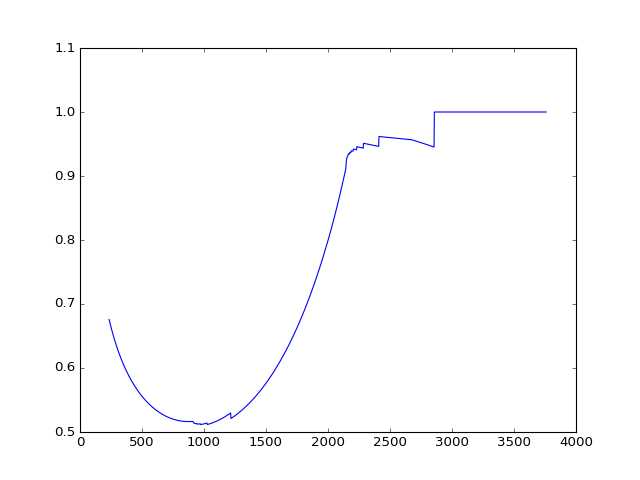

In [156]:
# just for checking myself
kol = (z_tr==1.35)
plt.close()
plt.plot(lam_tr[kol], tra_f[kol])


# Functions and constants

In [12]:
# Number of object 
id = 28720


# Cosmological constants
Omega_M = 0.2726             # Density of matter
Omega_K =  0.0               # Density of curvature
Omega_L = 0.7274             # Density of dark energy
h = 0.704

# For reference
c = 2.9927e10
pi = 3.14159265


# Collection of additional distance functions  
E   = lambda x: 1/np.sqrt(Omega_M * np.power(1+x,3) + Omega_L + Omega_K * np.power(1+x,2))
D_c = lambda x: (9.26e27/h) * integrate.quad(E, 0, x)[0]                                 # In centimeters
D_m = lambda x: D_c(x)
D_A = lambda x: D_m(x)/(1+x)
D_L = lambda x: np.power(1+x, 2) * D_A(x)

In [13]:
# The function of shifting the wavelength and shift amplitude of the flux
def func_1(z, n, x, y):
    l_mod  = (1+z) * x
    mod_flux = n * y
    return l_mod, mod_flux

In [123]:
# A function that takes into account the transmission curves and response function
def chi2(z, n, lcii, x, y, fil, lam_tr, flux_tr, z_tr, toplot=False):
    
    z = float("{0:.2f}".format(z))
    
    # Find the template corresponding to our z and n
    l_obs2, moh = func_1(z, n, x, y)
    lcii = np.array(lcii)

    # Sorting
    lcii = lcii[np.argsort(lcii)]

    # Add the absorption for objects 
    con = (z_tr == z)
    lam_tr = lam_tr[con]
    flux_tr = flux_tr[con]
    
    
    absorp = np.interp(l_obs2, lam_tr, flux_tr)
    
    #  type
    l_obs2 = np.array(l_obs2)
    moh = np.array(moh)
    
    
    sp_ext = np.zeros(len(l_obs2))
    for i in range (len(l_obs2)): 
        sp_ext[i] =  absorp[i] * moh[i] 
    

    sp_ext = sp_ext[np.argsort(l_obs2)]
    l_obs2 = l_obs2[np.argsort(l_obs2)]

    
    spectr = sp_ext.copy()
    lam_min = 10000000
    lam_max = 10
    
    # Add response function for all filters
    for i in range(len(fil)):
        res, n = get_filter_by_id(fil[i])
        
        # Load lambda and flux from filter response function
        x_res = res[:, 1]
        y_res = res[:, 2]
        

        # To avoid zero values
        x_filt = np.array(x_res[np.where(y_res>0.000001)])
        y_filt = np.array(y_res[np.where(y_res>0.000001)])
        
        
        # Load template lambda
        xx_tem = l_obs2[np.where((l_obs2 >= np.min(x_filt)) & (l_obs2 <= np.max(x_filt)))[0]]
        

        filt_int  = np.interp(xx_tem, x_filt, y_filt)              
        sp_ext[np.where((l_obs2 >= np.min(x_filt)) & (l_obs2 <= np.max(x_filt)))[0]] *= filt_int
        
  
        if (min(x_filt) < lam_min):
            lam_min = min(x_filt)
            
        if (max(x_filt) > lam_max):
            lam_max = max(x_filt)    
     
    # Cut flux which dont`t include our filters
    spt =  np.array(sp_ext[np.where((l_obs2 >= lam_min) & (l_obs2 <= lam_max))[0]])
    lamda = np.array(l_obs2[np.where((l_obs2 >= lam_min) & (l_obs2 <= lam_max))[0]])
       
    flo = np.interp(lcii, lamda, spt)

    return flo



# Fluxes and wavelengths

In [157]:
# The column numbers of the flux in the main catalog

#flux_cat = [9,12,15,18,21,24,27,30,33,36,39,42,45,48,51,54,57,60,63,66,69,72,75,\
#           78,81,84,87,89,91,93,95,97,99,101,103,105,107,109,111,113]


fl1 = np.linspace(9, 87, 27)
fl2 = np.linspace(89, 113, 13)
num_fc = np.hstack((fl1, fl2))


# The column numbers of the errors in the main catalog

#error_flux_cat = [10,13,16,19,22,25,28,31,34,37,40,43,46,49,52,55,58,61,64,67,70,\
#                 73,76,79,82,85,88,90,92,94,96,98,100,102,104,106,108,110,112,114]
    
    
efl1 = np.linspace(10, 88, 27)
efl2 = np.linspace(90, 114, 13)
num_efc = np.hstack((efl1, efl2))


fil_cat = ['F160W', 'U38', 'U', 'F435', 'B', 'V', 'F606cand', 'F606W', 'R', 'Rc','F775W', 'I', 'F814Wcand',\
          'F850LP', 'F850LPcand', 'F125W', 'J', 'tenisJ', 'F140W', 'H', 'tenisK', 'Ks', 'IRAC1', \
          'IRAC2', 'IRAC3', 'IRAC4', 'IA427', 'IA445', 'IA505', 'IA527', 'IA550', 'IA574', 'IA598',\
          'IA624', 'IA651', 'IA679', 'IA738', 'IA767', 'IA797', 'IA856']

# Central wavelengths of filters
lambd = np.array(([1.5396, 0.3637, 0.3750, 0.4318, 0.4563, 0.5396, 0.5921, 0.5919, 0.6443, 0.6517,\
                   0.7693, 0.7838, 0.8057, 0.9036, 0.9033, 1.2471, 1.2356, 1.2530, \
                   1.3924, 1.6496, 2.1574, 2.1667, 3.5569, 4.5020, 5.7450, 7.9158, 0.4260, 0.4443, 0.5061, 0.5259,\
                   0.5495, 0.5763,  0.6007, 0.6231, 0.6498, 0.6782, 0.7359, 0.7680, 0.7966, 0.8565]))



In [15]:
id

28720

In [16]:
# Spectrum from the catalog HST
flux_c = []
erflu_c = []
filt = []

for i in range(len(main_cat[0, :])):
    for j in range(len(num_fc)):
        if (i == num_fc[j]) & (main_cat[id - 1, i] > 0):
            flux_c.append(main_cat[id - 1, i])
            erflu_c.append(main_cat[id - 1, int(num_efc[j])])
            filt.append(j)


In [158]:
np.array(fil_cat)[filt]  # all filters that have flux for our object (id)

array(['F160W', 'F606cand', 'F606W', 'Rc', 'I', 'F850LPcand', 'F125W',
       'tenisJ', 'F140W', 'H', 'tenisK', 'IA767', 'IA797'], 
      dtype='<U10')

In [20]:
# Translate the wavelength into angstroms
lci = lambd[filt] * 10 ** 4

# Reproduce to a good type
flux_c = np.array(flux_c)
erflu_c = np.array(erflu_c)

# Translate the flow into nano Jansky
flux_c = [flux_c[i] * 10 ** (2.56) for i in range(len(flux_c))]
erflu_c = erflu_c * 10**2.56

# Reproduce to a good type again
flux_c = np.array(flux_c)
erflu_c = np.array(erflu_c)

# Sorting
flux_c = flux_c[np.argsort(lci)]
erflu_c = erflu_c[np.argsort(lci)]
lci = lci[np.argsort(lci)]

<IPython.core.display.Javascript object>


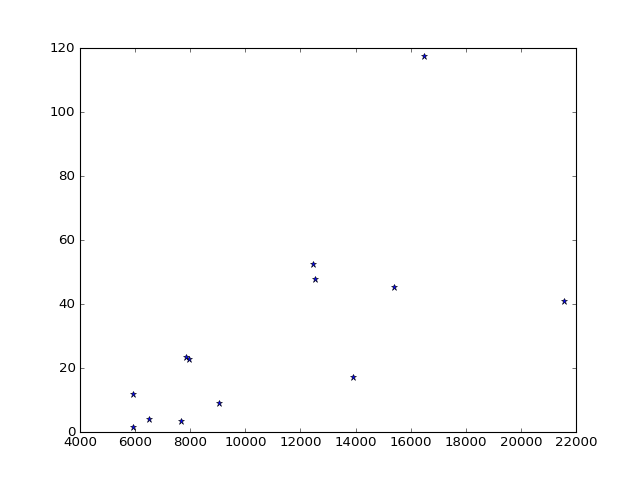

In [33]:
# just for checking myself
plt.close()
plt.plot(lci, flux_c, '*') # - spectrum from catalog for id object  

# Transmission functions ;;;;

In [26]:
fname = field + 'Eazy/' + 'goodss_3dhst.v4.1.translate'
filt_list = np.genfromtxt(fname, dtype=None)


fil = []
num_fil = []
for i, j in zip(filt_list[:, 1], np.linspace(0, 87, 88)):
    if j % 2 == 0:
        num_fil.append(np.array(i[1:]).astype(int))
        # print(np.array(i[1:]).astype(int))

        
for i, j in zip(filt_list[:, 0], np.linspace(0, 87, 88)):
    if j % 2 == 0:
        fil.append(np.array(i[2:]).astype(str))
        

num_fil = np.array(num_fil)
fil = np.array(fil)

# Filters and their numbers
fil = fil[np.argsort(num_fil)]
num_fil = num_fil[np.argsort(num_fil)]

# Delete filters that are not in the article
hi = [19, 20, 29, 33]
#print(np.delete(num_fil, hi))
#print(np.delete(fil, hi))

In [27]:
filters_info = []
for line in open( 'FILTER.RES.latest.info', 'r'):
    filters_info.append(np.array(line.split()))
filters_info = np.array(filters_info)

In [28]:
temp_filters = open('FILTER.RES.latest', 'r')
filters = []
filters_names = []
first = True

l = 0
for line in temp_filters:

    if line[0] == ' ':

        if not first:
            filters.append(np.array(temp))
            l += 1

        first = False
        filters_names.append(line.split())
        temp = []

    else:
        temp.append(np.array(line.split()).astype('float'))
        
# filters - include response function for each filter
# filters_name - include all filters name

filters = np.array(filters)
filters_names = np.array(filters_names)

In [29]:
# It return name and response function for each filter by id in num_fil
def get_filter_by_id(id):
    temp = np.array([a[0] for a in filters_info]).astype(int)
    name = filters_info[np.where(temp == id)[0][0]][1]
    names = np.array([a[1] for a in filters_names])
    #   print name
    return filters[np.where(name == names)[0][0]], name

<IPython.core.display.Javascript object>


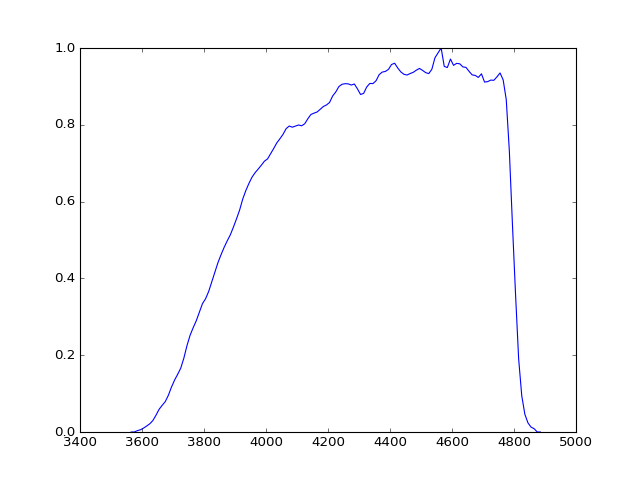

In [160]:
#  just for checking myself
p8,p9 = get_filter_by_id(num_fil[0])
p1 = p8[:, 1]
p2 = p8[:, 2]
plt.close()
plt.plot(p1,p2)

# MAIN CYCLE

In [180]:
z_tr = mar[:,2]
kol = (z_tr==1.5)
lam_tr = mar[:,1]
tra_f =  mar[:,0]

In [91]:
list[4]

'tweak_cosmos_v4/eazy_v1.1_sed5.dat'

In [149]:
z_list = np.arange(1,10,0.05)
n_list = np.logspace(-1,2,180)
len(z_list)

L = np.ones((len(n_list), len(z_list)))
k=4

x = np.genfromtxt(list[k])[:, 0]
y = np.genfromtxt(list[k])[:, 1]

xt = np.array([x[i] for i in range(0, len(x), 18)])
yt = np.array([y[i] for i in range(0, len(y), 18)])


print(x,y)
for j in range(len(z_list)):
        fitz = chi2(z_list[j], 1, lci, xt, yt, num_fil, mar[:,1],  mar[:,0], mar[:,2])
        for i in range(len(n_list)):
            L[i,j] = np.sum((flux_c - n_list[i]*fitz) ** 2 / (erflu_c ** 2))
            
H = np.amin(L, axis = 0)
PZ = H
len(PZ)

[  9.10000000e+01   9.40000000e+01   9.60000000e+01 ...,   1.20000000e+06
   1.40000000e+06   1.60000000e+06] [  1.66136000e-03   1.64337000e-03   1.66443000e-03 ...,   3.81241000e-08
   2.11512000e-08   1.35148000e-08]


180

<IPython.core.display.Javascript object>


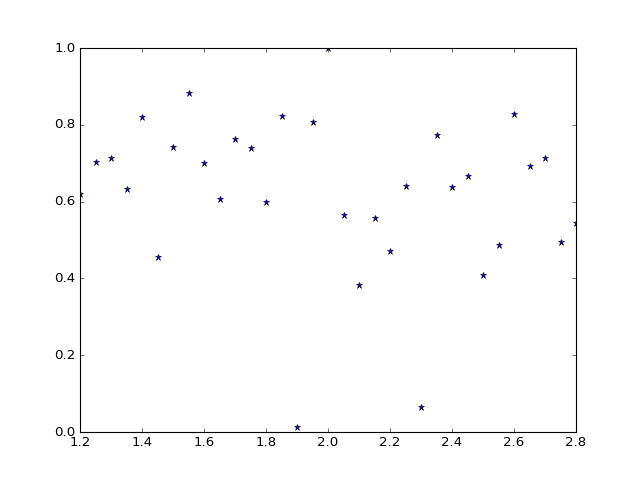

180


In [150]:
plt.close()
plt.plot(z_list, np.exp(-(PZ - np.min(PZ))), '*')
plt.xlim(1.2, 2.8)
print(len(PZ))


<IPython.core.display.Javascript object>


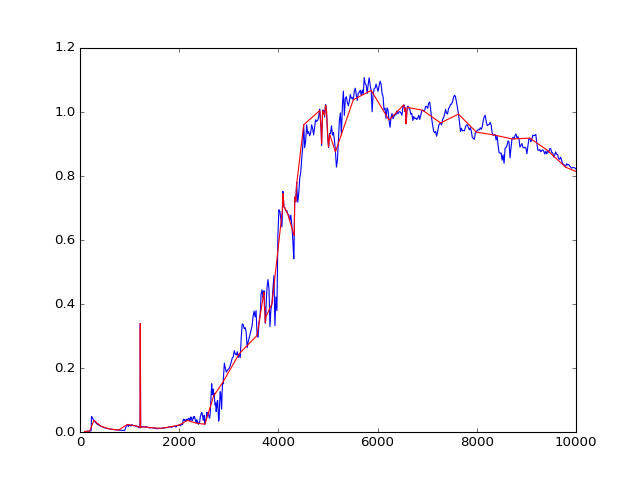

(0, 10000)

In [100]:
xt = [x[i] for i in range(0, len(x), 18)]
yt = [y[i] for i in range(0, len(y), 18)]

plt.close()
plt.plot(x,y)
plt.plot(xt, yt, color = 'red')
plt.xlim(0,10000)

<IPython.core.display.Javascript object>


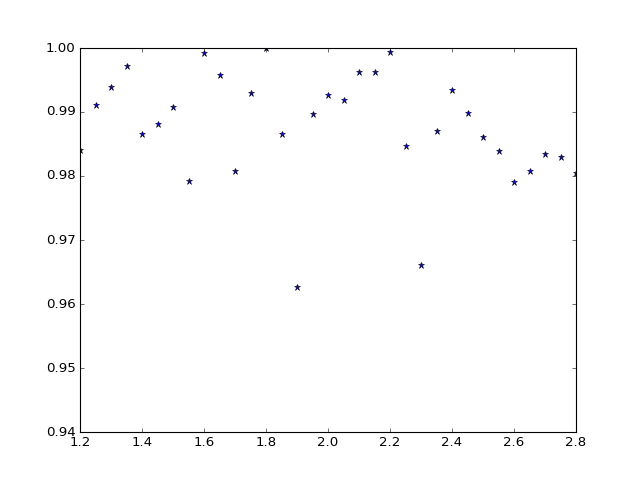

180


<IPython.core.display.Javascript object>


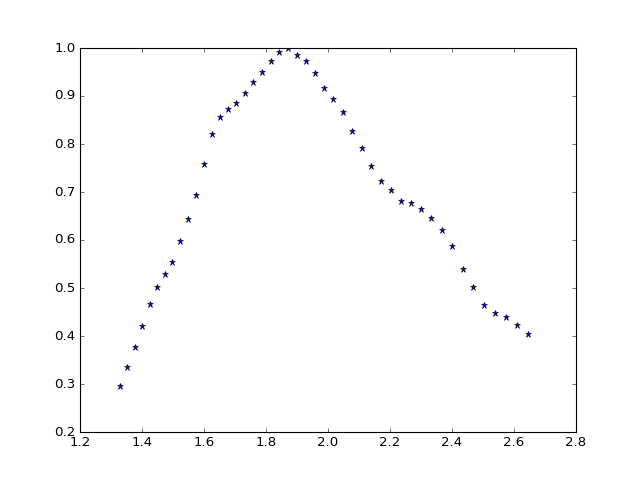

46

In [131]:
pzz3 = np.genfromtxt('goodss_3dhst.v4.1_28720.pz', skip_header=0)

fik = (pzz3[:,2]==5)
pz3 = np.exp(-0.5 * (pzz3[:,1][fik]- np.min(pzz3[:,1][fik])))
zgrid3 = pzz3[:,0][fik]
plt.close()
plt.plot(zgrid3, pz3, '*')
len(zgrid3)

# The end

In [90]:
L = np.ones((5, len(n_list), len(z_list)))
print(np.shape(L))


# The main cycle
for k in range (L.shape[0]):
    # Data from template
    x = np.genfromtxt(list[k])[:, 0]
    y = np.genfromtxt(list[k])[:, 1]

    for j in range(len(z_list)):
#         print(j)
        fitz = chi2(z_list[j], 1., lci, x, y, num_fil, mar[:,1],  mar[:,0], mar[:,2])
        for i in range(len(n_list)):
            #       print(i,j)
            L[k,i,j] = np.sum((flux_c - n_list[i]*fitz) ** 2 / (erflu_c ** 2))


Res = np.amin(L, axis=0)


(5, 90, 90)


TypeError: chi2() missing 3 required positional arguments: 'lam_tr', 'flux_tr', and 'z_tr'

In [89]:
Res
K = np.amin(Res, axis = 0)
print(K)

NameError: name 'Res' is not defined

<IPython.core.display.Javascript object>


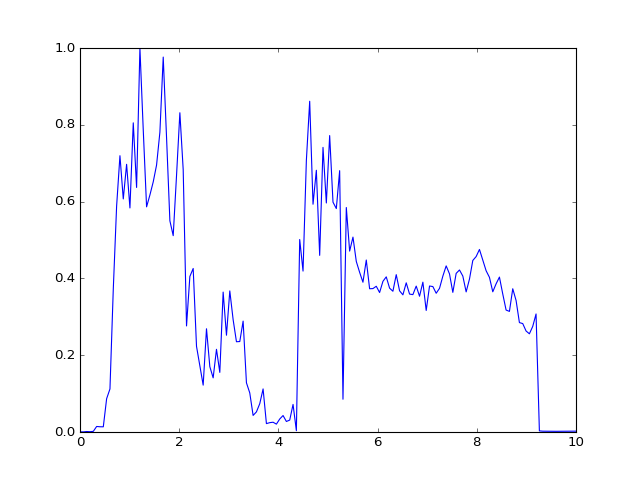

In [86]:
plt.close()
plt.plot( z_list, np.exp(-0.5*(K - min(K))))
plt.show()